In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

# Imports

In [ ]:
%matplotlib inline
%load_ext tensorboard
!pip install audiomentations
!pip install pip install focal-loss

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import math


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Dataset

## Dataset Utility

Contains utility function for generating the data for our model

In [ ]:
def pcen2bw(pcen):
  img = scale_minmax(pcen, 0, 255).astype(np.uint8)
  img = np.flip(img, axis=0) # put low frequencies at the bottom in image
  plt.imshow(img)
  return img

def mfcc_extract(y, sr=None, n_mfcc=13, split=False, num_seg=5, n_fft=2048, hop_length=512):
    SAMPLE_RATE = 4000
    TRACK_DURATION = 23 # measured in seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

    samples_per_seg = int(SAMPLES_PER_TRACK / num_seg)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_seg / hop_length)
    try:
        data = []
        if split:
          for seg in range(num_seg):
            start_seg = samples_per_seg * seg
            end_seg = start_seg + samples_per_seg
            mfccs = librosa.feature.mfcc(y=y[start_seg:end_seg], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfccs = mfccs.T
            if len(mfccs) == num_mfcc_vectors_per_segment:
              data.append(mfccs.tolist())
        else:
          mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
          data.append(mfccs)  
        return data
    except Exception as e:
        print("Error encountered while parsing files")
        print(e)
        return

def pcen_extract(y, sr=4000):
    try:
        S = librosa.feature.melspectrogram(y=y, sr=sr, power=1)
        pcen_S = librosa.pcen(S * (2 ** 31), sr=sr)
        return [S]
    except Exception as e:
        print("Error encountered while parsing file")
        print(e)
        return

In [ ]:
def extract_features(metadata, path, sr=None, pcen=False):
  features = []
  
  for index, row in metadata.iterrows():
    left_lung= path + '/{id}/{recording}_L.wav'.format(id=row['seal_id'], recording=row['rec_name'])
    right_lung= path + '/{id}/{recording}_R.wav'.format(id=row['seal_id'], recording=row['rec_name'])

    left_audio, sr = librosa.load(left_lung, sr=sr, duration=23)
    right_audio, sr = librosa.load(right_lung, sr=sr, duration=23)
    
    left_feautres = mfcc_extract(left_audio, sr, 40,split=True,num_seg=5)
    right_features = mfcc_extract(right_audio, sr, 40, split=True, num_seg=5)
    if pcen:
      left_feautres = pcen_extract(left_audio, sr)
      right_features = pcen_extract(right_audio, sr)
    
    for left_lung in left_feautres:
      features.append([left_lung, row['whistling_l'], row['rhonchus_l'], row['survival']])
    for right_lung in right_features:
      features.append([right_lung, row['whistling_r'], row['rhonchus_r'], row['survival']])
  
  features_df = pd.DataFrame(features, columns=['features', 'whistling', 'rhonchus', 'survival'])

  return features_df

### Generate Data

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

metadata = pd.read_csv('/content/drive/MyDrive/rug-bachelor-project/src/data/labels_int.csv')
metadata = metadata.sample(frac=1).reset_index(drop=True)

pcen = False

features_df = extract_features(metadata, '/content/drive/MyDrive/rug-bachelor-project/src/data/recordings', sr=None, pcen=pcen)

X = np.array(features_df.features.to_list())
y = np.array(features_df.whistling.to_list())
y1 = np.array(features_df.rhonchus.to_list())
y2 = np.array(features_df.survival.to_list())

print(np.unique(y2, return_counts=True))

(array([0, 1]), array([550, 160]))


# Classification
Contains the functions which build our models plus the training logic

## Focal Loss Function

In [ ]:
import numpy as np
from keras import backend as K
import tensorflow as tf

import dill

def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed


## Multi-task Model

In [ ]:
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D, Dropout, Input, Dense, BatchNormalization, Flatten, Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
def multi_model(input_shape, metrics, weights={'whistling': 1, 'rhonchus': 1}, optimizer='adam', conv_dr=0.25, fc_dr=0.5):
  # load model and specify a new input shape for images
  input = Input(shape=input_shape)

  x = Conv2D(16, kernel_size=2)(input)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(32, kernel_size=2)(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(64, kernel_size=2)(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.2)(x)

  x = Conv2D(128, kernel_size=2)(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.2)(x)

  #x = GlobalAveragePooling2D()(x)

  y = Dense(64, activation='relu')(x)
  y = Dropout(0.5)(y)

  y1 = Dense(128, activation='relu')(x)
  y1 = Dropout(0.5)(y1)

  output_whistling = Dense(1, activation='sigmoid', name='whistling')(GlobalAveragePooling2D()(x))
  output_rhonchus = Dense(4, activation='softmax', name='rhonchus')(GlobalAveragePooling2D()(x))
  #output_survival = Dense(1, activation='sigmoid', name='survival')(GlobalAveragePooling2D()(x))

  model = Model(inputs=input, outputs=[output_whistling, output_rhonchus])

  model.compile(loss={'whistling': 'binary_crossentropy', 'rhonchus': 'sparse_categorical_crossentropy'}, loss_weights=weights,
                optimizer=Adam(learning_rate=0.0004), metrics='accuracy')
  
  dot_img_file = '/content/drive/MyDrive/rug-bachelor-project/src/plots/model_1.png'
  tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

  model.summary()
  return model

## Survival Model

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from focal_loss import BinaryFocalLoss, SparseCategoricalFocalLoss


def multi_model_survival(input_shape, weights, optimizer='adam', conv_dr=0.25):
  visible = Input(shape=input_shape)
  x1 = Conv2D(16, kernel_size=2, activation='relu', padding='same')(visible)
  x1 = MaxPooling2D(pool_size=(2, 2))(x1)
  x1 = Dropout(conv_dr)(x1)

  x2 = Conv2D(32, kernel_size=2, activation='relu', padding='same')(x1)
  x2 = MaxPooling2D(pool_size=(2, 2))(x2)
  x2 = Dropout(conv_dr)(x2)

  x3 = Conv2D(64, kernel_size=2, activation='relu', padding='same')(x2)
  x3 = MaxPooling2D(pool_size=(2, 2))(x3)
  x3 = Dropout(conv_dr)(x3)
  
  x4 = Conv2D(128, kernel_size=2, activation='relu', padding='same')(x3)
  x4 = MaxPooling2D(pool_size=(2, 2))(x4)
  x4 = Dropout(conv_dr)(x4)
  
  x = GlobalAveragePooling2D()(x4)
  
  y = Dense(1, activation='sigmoid', name = 'survival')(x)
  y1 = Dense(4, activation='softmax', name= 'rhonchus')(GlobalAveragePooling2D()(x3))
  y2 = Dense(1, activation='sigmoid', name = 'whistling')(GlobalAveragePooling2D()(x2))

  model = Model(inputs=visible, outputs=[y, y1,y2])
  model.compile(loss={'survival': 'binary_crossentropy','whistling': 'binary_crossentropy', 'rhonchus': 'sparse_categorical_crossentropy'},
                loss_weights=weights, optimizer=Adam(clipnorm=1., learning_rate=0.0005), metrics='accuracy')
  return model



## Multi-task Pre-trained Model

In [ ]:
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.optimizers import SGD

def multi_model_trained(input_shape, metrics, weights={'whistling': 1, 'rhonchus': 1}, optimizer='adam', conv_dr=0.25, fc_dr=0.5):
  # load model and specify a new input shape for images
  model_input = Input(shape=input_shape)
  base_model = ResNet50(include_top=False, weights=None, input_shape=input_shape)

  for layer in base_model.layers[:-143]:
    layer.trainable = False

  x = base_model(model_input)
  x = GlobalAveragePooling2D()(x)
  
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)

  y = Dense(128, activation='relu')(x)
  y = Dropout(0.5)(y)
  y = Dense(64, activation='relu')(y)
  y = Dropout(0.5)(y)

  y1 = Dense(128, activation='relu')(x)
  y1 = Dropout(0.5)(y1)
  y1 = Dense(64, activation='relu')(y1)
  y1 = Dropout(0.5)(y1)

  output_whistling = Dense(1, activation='sigmoid', name='whistling')(y)
  output_rhonchus = Dense(4, activation='softmax', name='rhonchus')(y1)

  model = Model(inputs=model_input, outputs=[output_whistling, output_rhonchus])

  model.compile(loss={'whistling': 'binary_crossentropy', 'rhonchus': 'sparse_categorical_crossentropy'},
                loss_weights=weights,
                optimizer='adam', metrics='accuracy')
  model.summary()
  return model

## Training

In [ ]:
# Models Configuration

test_metrics = {'whistling': 'accuracy', 'rhonchus': 'accuracy'}
#weights={'whistling': 0.8, 'rhonchus': 1e-1, 'survival': 1e-1}

#test_metrics = {'whistling': 'accuracy', 'rhonchus': 'accuracy'}
weights={'whistling': 0.7, 'rhonchus': 0.3}

batch=32
epochs=300

### PCEN Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

x_train, x_test, y_train, y_test, y1_train, y1_test = train_test_split(X, y ,y1, test_size=0.1, random_state=42)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

input_shape = (x_train.shape[1], x_train.shape[2], 1)

path_to_model='/content/drive/MyDrive/rug-bachelor-project/src/saved_models/weights.best.multitask_pcen.hdf5'

model = multi_model_trained(input_shape=input_shape, metrics=test_metrics, weights=weights)

checkpoint = ModelCheckpoint(filepath=path_to_model, verbose=1, save_best_only=True)
history = model.fit(x_train, {'whistling': y_train, 'rhonchus': y1_train}, batch_size=batch,
                             epochs=epochs, validation_data=(x_test, [y_test, y1_test]),
                             callbacks=[checkpoint], verbose=1, shuffle=True)

NameError: ignored

### MFCC Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold

path_to_model='/content/drive/MyDrive/rug-bachelor-project/src/saved_models/weights.best.multitask_mfcc.hdf5'

kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cvscores_whistling = []
cvscores_rhonchus = []

primary_model=None
max_accuracy=-1
fold = 0
best_history = None
for train, test in kfold.split(X, y, y1):
  x_train, x_test, y_train, y_test, y1_train, y1_test= X[train], X[test], y[train], y[test], y1[train], y1[test]
  
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

  input_shape = (x_train.shape[1], x_train.shape[2], 1)
  model = multi_model(input_shape=input_shape, metrics=test_metrics, weights=weights, conv_dr=0.2)

  file_path = '/content/drive/MyDrive/rug-bachelor-project/src/saved_models/weights.best.multitask_mfcc{i}.hdf5'.format(i=fold)
  checkpoint = ModelCheckpoint(filepath=file_path, verbose=1, save_best_only=True)
  history = model.fit(x_train, {'whistling': y_train, 'rhonchus': y1_train}, batch_size=batch,
                              epochs=epochs, validation_data=(x_test, {'whistling': y_test, 'rhonchus': y1_test}),
                              callbacks=[checkpoint], verbose=1, shuffle=True)
  # evaluate the model
  scores = model.evaluate(x_test, [y_test, y1_test], verbose=0)
  cvscores_whistling.append(scores[3] * 100)
  cvscores_rhonchus.append(scores[4] * 100)

  if scores[3] > max_accuracy:
    max_accuracy = scores[3]
    primary_model = file_path
    best_history = history
  fold += 1

w_accuracy = float("{:.2f}".format(np.mean(cvscores_whistling))) 
r_accuracy = float("{:.2f}".format(np.mean(cvscores_rhonchus))) 
w_dev = float("{:.2f}".format( np.std(cvscores_whistling)))
r_dev = float("{:.2f}".format(np.std(cvscores_rhonchus))) 

scores = [w_accuracy, w_dev, r_accuracy, r_dev]

pd.DataFrame(scores).to_csv('/content/drive/MyDrive/rug-bachelor-project/src/reports/kfolds.csv')
print("whistling: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores_whistling), np.std(cvscores_whistling)))
print("rhonchus: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores_rhonchus), np.std(cvscores_rhonchus)))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 36, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 35, 39, 16)   80          input_3[0][0]                    
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 35, 39, 16)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 17, 19, 16)   0           activation_8[0][0]               
____________________________________________________________________________________________

KeyboardInterrupt: ignored

### Survival Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold 

path_to_model='/content/drive/MyDrive/rug-bachelor-project/src/saved_models/weights.best.multitask_mfcc.hdf5'

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores_whistling = []
cvscores_rhonchus = []

primary_model=None
max_accuracy=-1
fold = 0
x_test=None
for train, test in kfold.split(X, y, y1):
  x_train, x_test, y_train, y_test, y1_train, y1_test, y2_train, y2_test, = X[train], X[test], y[train], y[test], y1[train], y1[test], y2[train], y2[test]

  print(np.unique(y2_train, return_counts=True))
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

  print(y_test.shape, y1_test.shape)
  input_shape = (x_train.shape[1], x_train.shape[2], 1)
  model = multi_model_survival(input_shape=input_shape, weights=weights, conv_dr=0.2)

  file_path = '/content/drive/MyDrive/rug-bachelor-project/src/saved_models/weights.best.multitask_mfcc{i}.hdf5'.format(i=fold)
  checkpoint = ModelCheckpoint(filepath=file_path, verbose=1, save_best_only=True)
  history = model.fit(x_train, {'whistling': y_train, 'rhonchus': y1_train, 'survival': y2_train}, batch_size=batch,
                              epochs=epochs, validation_data=(x_test, {'whistling': y_test, 'rhonchus': y1_test, 'survival': y2_test}),
                              callbacks=[checkpoint], verbose=1, shuffle=True)
  # evaluate the model
  scores = model.evaluate(x_test, [y_test, y1_test, y2_test], verbose=0)
  #cvscores_whistling.append(scores[3] * 100)
  #cvscores_rhonchus.append(scores[4] * 100)

  #if scores[3] > max_accuracy:
  #  max_accuracy = scores[3]
  #  primary_model = file_path
  fold += 1

#w_accuracy = float("{:.2f}".format(np.mean(cvscores_whistling))) 
#r_accuracy = float("{:.2f}".format(np.mean(cvscores_rhonchus))) 
#w_dev = float("{:.2f}".format( np.std(cvscores_whistling)))
#r_dev = float("{:.2f}".format(np.std(cvscores_rhonchus))) 

#scores = [w_ accuracy, w_dev, r_accuracy, r_dev]

#pd.DataFrame(scores).to_csv('/content/drive/MyDrive/rug-bachelor-project/src/reports/kfolds.csv')
#print("whistling: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores_whistling), np.std(cvscores_whistling)))
#print("rhonchus: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores_rhonchus), np.std(cvscores_rhonchus)))



## Prediction

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve

model = load_model(primary_model)

print(x_test.shape)
#survival_pred, rhonchus_pred, whistling_pred = model.predict(x_test)
whistling_pred, rhonchus_pred = model.predict(x_test)

#survival_pred = (survival_pred > 0.5).astype('int32')
whistling_pred = (whistling_pred > 0.5).astype('int32')
rhonchus_pred = [np.argmax(p) for p in rhonchus_pred]

(118, 36, 40, 1)


# Results
Contains all the utility functions for generating all plots and reports

## Classification Reports

In [ ]:
whistling_report = classification_report(y_test, whistling_pred, output_dict=True)
#survival_report = classification_report(y2_test, survival_pred, output_dict=True)
rhonchus_report = classification_report(y1_test, rhonchus_pred, output_dict=True)

whistling_df = pd.DataFrame(whistling_report).transpose()
rhonchus_df = pd.DataFrame(rhonchus_report).transpose()
#survival_df = pd.DataFrame(survival_report).transpose()

print(whistling_df)
print(rhonchus_df)
#print(survival_df)

whistling_df.to_csv("/content/drive/MyDrive/rug-bachelor-project/src/reports/whistling_classification.csv")
rhonchus_df.to_csv("/content/drive/MyDrive/rug-bachelor-project/src/reports/rhonchus_classification.csv")

              precision    recall  f1-score     support
0              0.845238  0.898734  0.871166   79.000000
1              0.764706  0.666667  0.712329   39.000000
accuracy       0.822034  0.822034  0.822034    0.822034
macro avg      0.804972  0.782700  0.791747  118.000000
weighted avg   0.818622  0.822034  0.818669  118.000000
              precision    recall  f1-score     support
0              0.486486  0.500000  0.493151   36.000000
1              0.631579  0.720000  0.672897   50.000000
2              0.200000  0.066667  0.100000   15.000000
3              0.578947  0.647059  0.611111   17.000000
accuracy       0.559322  0.559322  0.559322    0.559322
macro avg      0.474253  0.483431  0.469290  118.000000
weighted avg   0.524869  0.559322  0.536332  118.000000


## Plots Utility

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

def plot_confusion_matrix(cm, classes, save_path,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = float('%.2f' % (cm))
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(save_path)
    plt.show()

def plot_roc(fpr, tpr, auc, save_path):
    """
        This function plots the ROC-AUC Curve
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.savefig(save_path)
    plt.show()
  
def plot_history(history, save_path):
    #fig, axs = plt.subplots(nrows=2, ncols=2)
    fig = plt.figure(constrained_layout=False, figsize=(8, 4))

    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    ax1.plot(history.history["whistling_accuracy"], label='Whistling Train')
    ax1.plot(history.history["val_whistling_accuracy"], label='Whistling Test')

    ax2.plot(history.history["rhonchus_accuracy"], label='Rhonchus Train')
    ax2.plot(history.history["val_rhonchus_accuracy"], label='Rhonchus Test')

    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    ax1.set_title("CNN Accuracy")

    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="lower right")
    ax2.set_title("CNN Accuracy")

    ax3.plot(history.history["loss"], label='Train Error')
    ax3.plot(history.history["val_loss"], label='Test Error')
    ax3.set_ylabel("Error")
    ax3.set_xlabel("Epoch")
    ax3.legend(loc="upper right")
    ax3.set_title("CNN Error")

    plt.savefig(save_path)
    plt.show()

## Validation

### Learning Curve

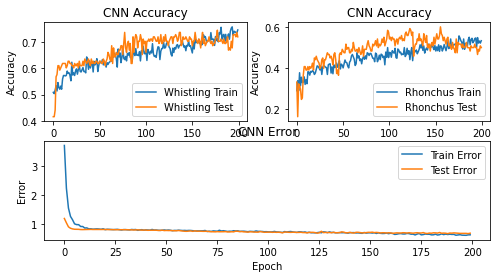

In [ ]:
plot_history(best_history, '/content/drive/MyDrive/rug-bachelor-project/src/plots/learning_curve.png')

### Confusion Matrix

Confusion matrix, without normalization


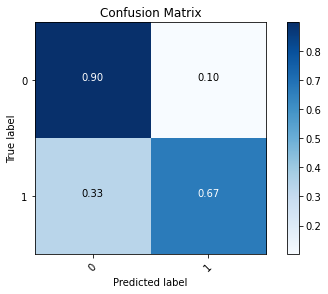

Confusion matrix, without normalization


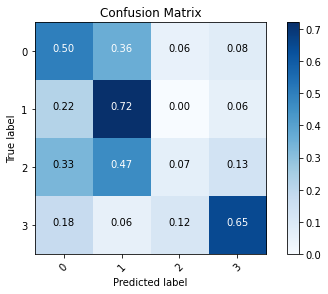

In [ ]:
whistling_cm = confusion_matrix(y_test, whistling_pred,normalize='true')
rhonchus_cm = confusion_matrix(y1_test, rhonchus_pred,normalize='true')
#survival_cm = confusion_matrix(y2_test, survival_pred,normalize='true')

plot_confusion_matrix(whistling_cm, classes=[0, 1], title='Confusion Matrix',
                      save_path='/content/drive/MyDrive/rug-bachelor-project/src/plots/whistling_cm.png')
plot_confusion_matrix(rhonchus_cm, classes=[0, 1, 2, 3], title='Confusion Matrix',
                      save_path='/content/drive/MyDrive/rug-bachelor-project/src/plots/rhonchus_cm.png')
#plot_confusion_matrix(survival_cm, classes=[0, 1], title='Confusion Matrix',
#                      save_path='/content/drive/MyDrive/rug-bachelor-project/src/plots/survival_cm.png')


### Roc Curve


[0.         0.10126582 1.        ]


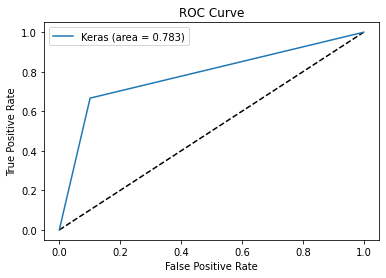

In [ ]:
y_pred = whistling_pred.ravel()
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(y_test.tolist())
auc2 = metrics.auc(fpr, tpr)
print(fpr)
plot_roc(fpr, tpr, auc2, '/content/drive/MyDrive/rug-bachelor-project/src/plots/whistling_roc.png')

## Class Activation Maps (CAM)

In [ ]:
from scipy.ndimage.measurements import label
import keras
import cv2
from google.colab.patches import cv2_imshow
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

def get_heatmap(model, layer_index, img, original_img):
  conv_layer = 'conv2d_11'
  
  width, height = original_img.shape[0], original_img.shape[1]

  class_weights = model.layers[layer_index].get_weights()[0]
  final_conv_layer = get_output_layer(model, conv_layer)
  get_output = keras.backend.function([model.layers[0].input],
                                  [final_conv_layer.output, model.layers[layer_index].output])
  [conv_outputs, predictions] = get_output([img])
  conv_outputs = conv_outputs[0, :, :, :]

  print(predictions)
  # Create the class activation map.
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[1:3])

  for i, w in enumerate(class_weights[np.argmax(predictions), :]):
    cam += w * conv_outputs[i, :, :]

  cam /= np.max(cam)
  cam = cv2.resize(cam, (height, width))
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
  heatmap[np.where(cam < 0.3)] = 0

  return heatmap

def generate_cam(audio_path, rec_name, rhonchus_label, whistling_label):

  y, sr = librosa.load(audio_path, sr=None)
  mels = pcen_extract(y=y, sr=sr)

  original_img = scale_minmax(mels, 0, 255).astype(np.uint8)
  original_img = np.flip(original_img, axis=0) # put low frequencies at the bottom in image

  plt.show()
  # Get the color map by name:
  cm = plt.get_cmap('inferno')
  colored_img = cm(original_img)
  colored_img = (colored_img[:, :, :3] * 255).astype(np.uint8)

  features = mels.reshape((1, mels.shape[0], mels.shape[1], input_channels))

  whistling_heatmap = get_heatmap(model=model, layer_index=-2, img=features, original_img=colored_img)
  rhonchus_heatmap = get_heatmap(model=model, layer_index=-1, img=features, original_img=colored_img)

  whistling_cam = (whistling_heatmap*0.8 + colored_img).astype(np.uint8)
  rhonchus_cam = (rhonchus_heatmap*0.8 + colored_img).astype(np.uint8)

  fig, ax = plt.subplots(nrows=2,figsize=(8,10))
  librosa.display.specshow(mels, x_axis='time', y_axis='mel', ax=ax[0])
  ax[0].set(title='Original Image', xlabel=None)
  ax[0].label_outer()
  ax[1].set(title='Class Activation Map')
  ax[1].imshow(whistling_cam)

  plt.savefig('/content/drive/MyDrive/rug-bachelor-project/src/plots/cams/whistling_{name}_{r}{w}.png'.format(name=rec_name, r=rhonchus_label, w=whistling_label))
  plt.show()

  fig, ax = plt.subplots(nrows=2,figsize=(8,10))
  librosa.display.specshow(mels, x_axis='time', y_axis='mel', ax=ax[0])
  ax[0].set(title='Original Image', xlabel=None)
  ax[0].label_outer()
  ax[1].set(title='Class Activation Map')
  ax[1].imshow(rhonchus_cam)

  plt.savefig('/content/drive/MyDrive/rug-bachelor-project/src/plots/cams/rhonchus_{name}_{r}{w}.png'.format(name=rec_name, r=rhonchus_label, w=whistling_label))
  plt.show()

for index, row in metadata.iterrows():
  left_lung='/content/drive/MyDrive/rug-bachelor-project/src/data/recordings/{id}/{recording}_L.wav'.format(id=row['seal_id'], recording=row['rec_name'])
  right_lung='/content/drive/MyDrive/rug-bachelor-project/src/data/recordings/{id}/{recording}_R.wav'.format(id=row['seal_id'], recording=row['rec_name'])

  rl, rr, wl, wr = row['rhonchus_l'], row['rhonchus_r'], row['whistling_l'], row['whistling_r']

  generate_cam(left_lung, row['rec_name']+'_L', rl, wl)
  generate_cam(right_lung, row['rec_name']+'_R', rr, wr)

## PCEN Representation

27.632


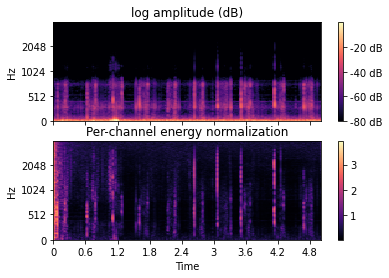

27.632


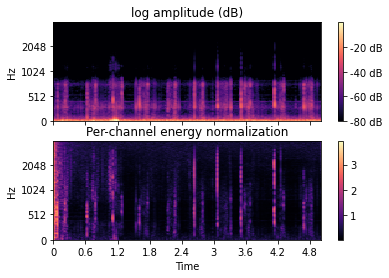

27.568


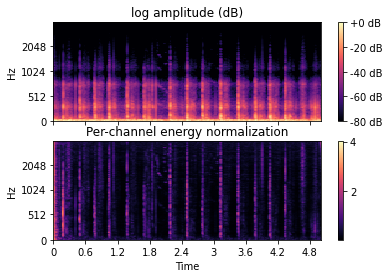

27.76


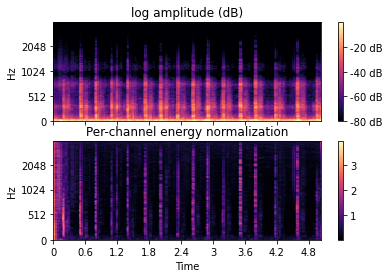

30.0


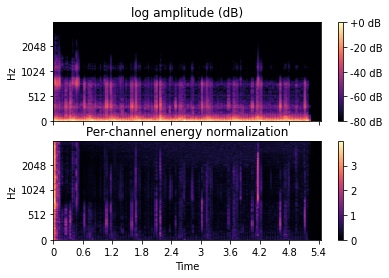

28.848


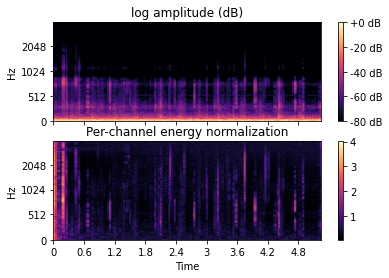

28.08


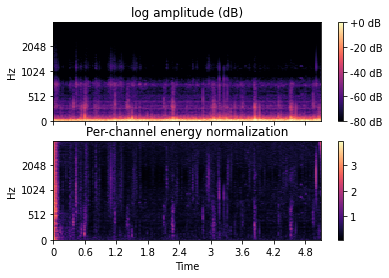

28.976


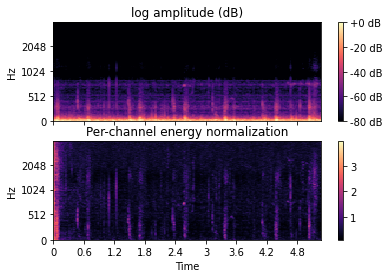

28.848


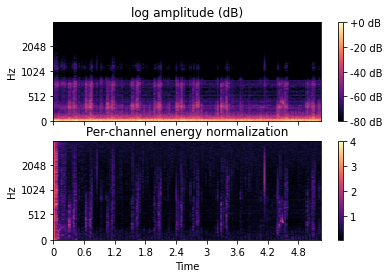

28.848


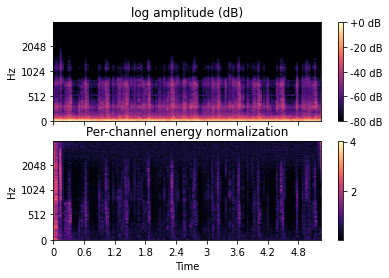

27.76


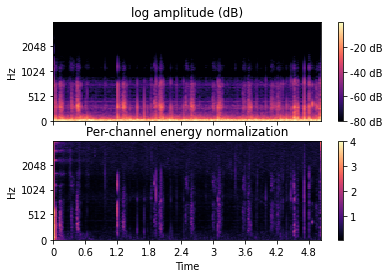

30.0


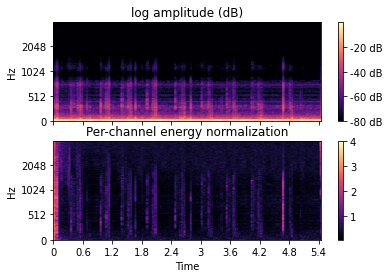

29.04


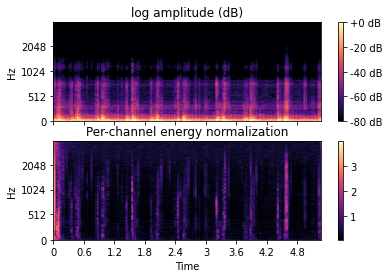

28.848


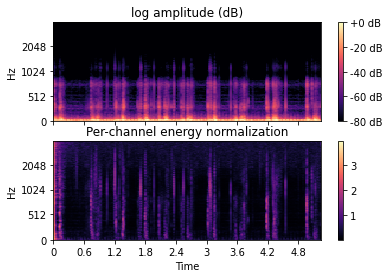

28.272


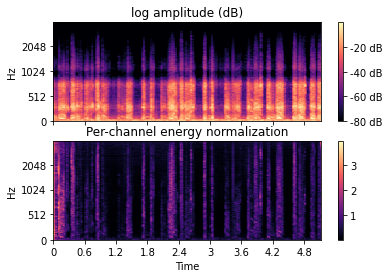

30.0


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
for index, row in metadata.iterrows():
  left_lung='/content/drive/MyDrive/rug-bachelor-project/src/data/recordings/{id}/{recording}_L.wav'.format(id=row['seal_id'], recording=row['rec_name'])
  right_lung='/content/drive/MyDrive/rug-bachelor-project/src/data/recordings/{id}/{recording}_R.wav'.format(id=row['seal_id'], recording=row['rec_name'])

  rl, rr, wl, wr = row['rhonchus_l'], row['rhonchus_r'], row['whistling_l'], row['whistling_r']

  # We recommend scaling y to the range [-2**31, 2**31[ before applying
  # PCEN's default parameters. Furthermore, we use power=1 to get a
  # magnitude spectrum instead of a power spectrum.


  lungs = [left_lung, right_lung]
  for i, lung in enumerate(lungs):
    y, sr = librosa.load(lung, sr=None, duration=30)
    print(librosa.get_duration(y, sr))
    S = librosa.feature.melspectrogram(y, sr=sr, power=1)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    pcen_S = librosa.pcen(S * (2**31))
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
    img = librosa.display.specshow(log_S, x_axis='time', y_axis='mel', ax=ax[0], fmax=4000)
    ax[0].set(title='log amplitude (dB)', xlabel=None)
    ax[0].label_outer()
    imgpcen = librosa.display.specshow(pcen_S, x_axis='time', y_axis='mel', ax=ax[1], fmax=4000)
    ax[1].set(title='Per-channel energy normalization')
    fig.colorbar(img, ax=ax[0], format="%+2.0f dB")
    fig.colorbar(imgpcen, ax=ax[1])
    #if i == 0:
    #  plt.savefig('/content/drive/MyDrive/rug-bachelor-project/src/plots/pcen/whistling_{name}_{r}{w}.png'.format(name=row['rec_name']+'_L', r=rl, w=wl))
    #else:
    #  plt.savefig('/content/drive/MyDrive/rug-bachelor-project/src/plots/pcen/whistling_{name}_{r}{w}.png'.format(name=row['rec_name']+'_R', r=rr, w=wr))
    plt.show()


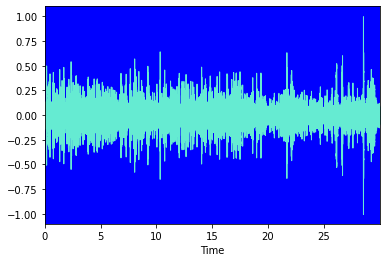

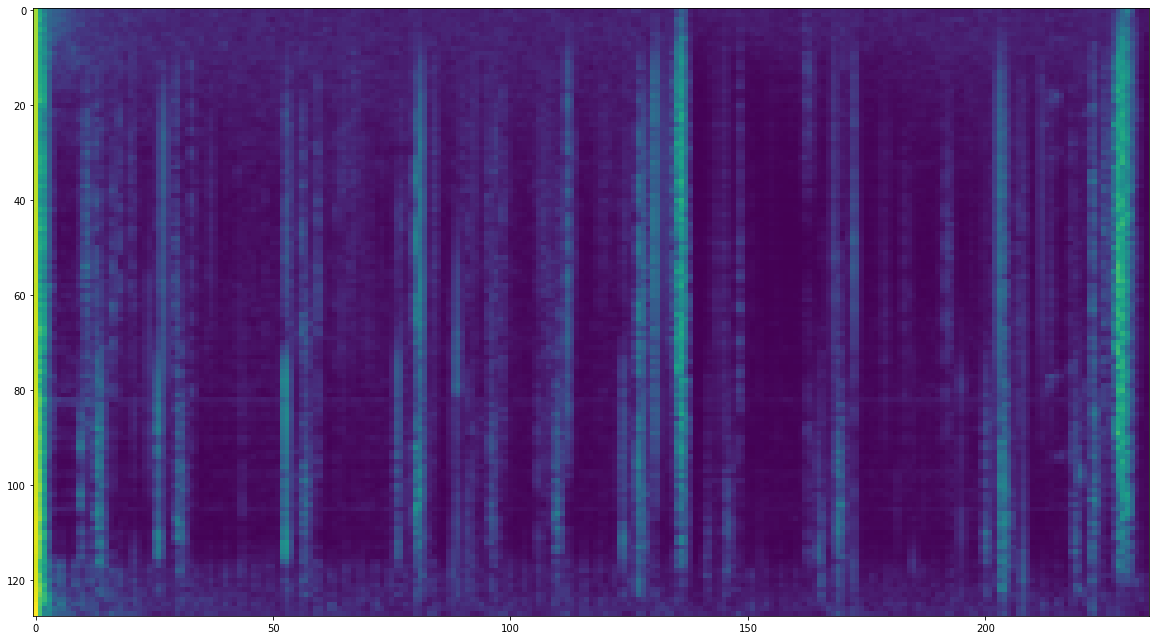

In [ ]:
import matplotlib.pyplot as plt

def spectrogram_image(y, sr, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    pcen_S = librosa.pcen(S * (2 ** 31))
    mels = np.log(pcen_S + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(pcen_S, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image

    plt.imshow(img)

y, sr = librosa.load('/content/drive/MyDrive/rug-bachelor-project/src/data/recordings/PV18272/PV18272_311218_L.wav', duration=30, sr=None)

S = librosa.feature.melspectrogram(y=y, sr=sr, power=1)
pcen_S = librosa.pcen(S * (2 ** 31))

librosa.display.waveplot(y, sr=sr, color='#65ebd2')
plt.figure(figsize=(20,12))
spectrogram_image(y, sr, 128)




